<img src="./images/film_strip_img.jpg">

#       Recommendations for the New Microsoft Movie Studio

# Overview and Business Problem

Microsoft wishes to enter a market still growing internationally (even though domestic box office is delcining slightly) which reached $42.5 billion in 2019 before the pandemic.  

Our task is to use data to explore the types of movies that are doing well at the box office, and then make appropriate recommendations to the head of the new Microsoft Studio. 

# Data Understanding

We are working with datasets from five sources:  
 * The Internet Movie Database (IMDb): A popular movie reference website.  Our data consists of six files from IMDb with varying numbers of records, from over one million to less that 74,000.
 * The Numbers (TN):  An online movie data site, self styled as "Where Data and the Movie Business Meet"; 5782 records.  
 * The Movie Database (TMDb):  A competitor of IMDb; 26,517 records.  
 * Box Office Mojo (BOM):  A popular online box office receipts reference; 3387 records. 
 * Rotten Tomatoes (RT):  A popular online critics aggregator.  Our data consists of 3 files, two provided containing over 1500 movies and a third, webscraped dataset from Kaggle containing 10,847 records.
 
Our overall strategy is to merge the six IMDb datasets with TN, TMDb, and finally BOM.  We want to compare various independent variables against box office returns.  We can use domestic gross box office from the BOM and TN datasets, as well as worldwide gross receipts from TN.  Then, by using the production budget values from TN, we can determine worldwide net receipts. Worldwide net receipts will be our dependent variable.  

The two smaller RT datasets contain no movie titles that can be merged with the others (and only contain what is surmised to be gross domestic receipts).  Therefore these datasets can be used for expoloratory purposes and to validate other results.  The RT Kaggle dataset, however, can be merged with the larger datset for further exploration. 

# Data Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import ast
from calendar import month_name


%matplotlib inline
sns.set_context('talk')

## Importing the data

In [2]:
# Manav's Data
imdb_title = pd.read_csv('data/imdb.title.principals.csv.gz')
imdb_crew = pd.read_csv('data/imdb.title.crew.csv.gz')
rating_1 = pd.read_csv('data/imdb.title.ratings.csv.gz')

# Nate's Data
title_basics_imdb = pd.read_csv('data/imdb.title.basics.csv.gz')
akas_imdb = pd.read_csv('data/imdb.title.akas.csv.gz')
name_basics_imdb = pd.read_csv('data/imdb.name.basics.csv.gz')

# Nina's Data
tn_cleaned = pd.read_csv('data/tn_cleaned.csv')
tndb_cleaned = pd.read_csv('data/tmdb_cleaned.csv')
cleaned_bom = pd.read_csv('data/cleaned_bom.csv')

# Ben's Data
rt_kaggle = pd.read_csv('data/rotten_tomatoes_movies.csv')
rt_movies = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')

## Begin Data Cleaning  (Nate W.)

### imdb.title.basics, imdb.title.akas, imdb.name.basics

In [3]:
# making copies of the original dfs to work on 

title2 = title_basics_imdb.copy(deep=True)
title3 = title_basics_imdb.copy(deep=True) # the test df for the test df...nan
akas2 = akas_imdb.copy(deep=True)
names2 = name_basics_imdb.copy(deep=True)
crew2 = imdb_crew.copy(deep=True)

### Beginning to clean and alter the data frames

In [4]:
# remove all directors from the names2 df that have died
names2 = names2.loc[names2['death_year'].isna()].reset_index(drop=True)

In [5]:
# dropped the now-vacant death_year column
names2.drop(['death_year'], axis = 1, inplace=True)
# also dropping the birth_year column
names2.drop(['birth_year'], axis=1, inplace=True)

In [6]:
#Reasigning the name of the first column in akas2 from title_id to tconst
#so title2 and akas2 can be compared more readily.
akas2.rename(columns = {'title_id':'tconst'}, inplace = True)

In [7]:
# getting rid of any rows outside of Ben's Box-Office dates range of 2015 - 2018
title2 = title2.loc[(title2['start_year'] >= 2015) & (title2['start_year'] <= 2018)]
#title2
# that looks good. Now let's make sure akas2 matches those years
#len(title2)

In [8]:
#If akas2['tconst'] not in title2['tconst'] within 2015-2018, drop those rows in akas2['tconst']
#something like:  if akas2['tconst'] not in title2['tconst'] drop akas2['tconst']

common = akas2.merge(title2, on=["tconst"])
akas2 = result = akas2[~akas2.tconst.isin(common.tconst)]
#len(akas2)

Note: In the above cell the reason that akas2 has more rows is that 
there are multiple titles in several different
languages, sharing the same tconst label. 
There are, however, no tconst in akas2 
that are not in title2 and vise versa.

### Steps toward achieving ***first normal form***

In [9]:
# get rid of any professions other than writer and director or writer/director under primary_profession column
profs = names2['primary_profession'].str.split(',').explode()
filtered_profs = profs[profs.isin(['writer', 'writer director', 'director'])]
filtered_profs.groupby(filtered_profs.index).agg(','.join)
names2 = names2.drop('primary_profession', axis=1).join(filtered_profs.groupby(filtered_profs.index).agg(','.join), how='inner')

### Failure at searching for highest grossin films by title

In [10]:
films = title2['primary_title']
star_wars = films[films.isin(['Star Wars: Episode VII - The Force Awakens'])]
star_wars
title2.loc[41443, :]

tconst                                              tt2488496
primary_title      Star Wars: Episode VII - The Force Awakens
original_title     Star Wars: Episode VII - The Force Awakens
start_year                                               2015
runtime_minutes                                           136
genres                               Action,Adventure,Fantasy
Name: 41443, dtype: object

In [11]:
# Now we have the tconst of Star Wars: Episode VII. 
# Let's find who the writer's directors were by tconst

extra_directors = names2[names2.known_for_titles.str.contains('tt2488496', na=False)].head(5)

Note: The above list points out that just because we have a primary profession 
narrowed down to writer and director, that doesn't mean that when we search for
that tconst under known_for_titles it will return only our desired director.
Other actors and producers who worked in that capacity are also 
directors on other projects. Therefor their name is still associated with the
profession director/writer and are returned within our search along with the 
real writer and director.

In [12]:
title2.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


* it appears that **title.basics** gets us the vital statistics of the movie
* the **title.basics** original_title col might match up with the **akas** title col
* might be overlap with original_title/**akas** title cols


In [13]:
akas2.head(10)

,tconst,ordering,title,region,language,types,attributes,is_original_title
48,tt0381957,1,Cloud Cuckoo Land,GB,NaN,NaN,NaN,0.0
49,tt0401729,10,Джон Картер: Мiж двох свiтiв,UA,NaN,NaN,NaN,0.0
50,tt0401729,11,John Carter of Mars,US,NaN,working,NaN,0.0
51,tt0401729,12,A Princess of Mars,US,NaN,working,NaN,0.0
52,tt0401729,13,John Carter - Entre dos mundos,AR,NaN,imdbDisplay,NaN,0.0
53,tt0401729,14,John Carter Maaveeran,IN,ta,NaN,dubbed version,0.0
54,tt0401729,15,Džonas Karteris,LT,NaN,NaN,NaN,0.0
55,tt0401729,16,John Carter,PT,NaN,imdbDisplay,NaN,0.0
56,tt0401729,17,John Carter: Mezi dvěma světy,CZ,NaN,NaN,NaN,0.0
57,tt0401729,18,John Carter: Ανάμεσα σε δύο κόσμους,GR,NaN,NaN,NaN,0.0


* It appears that what we'll find in **akas** is the names of movies in other languages
* change is_original_title from float to int

In [14]:
names2.head(10)

,nconst,primary_name,known_for_titles,primary_profession
2,nm0062070,Bruce Baum,"tt1470654,tt0363631,tt0104030,tt0102898",writer
5,nm0062879,Ruel S. Bayani,"tt2590280,tt0352080,tt0216559,tt2057445",director
10,nm0064023,Bryan Beasley,"tt3501180,tt1485100,tt1358897,tt1387162","director,writer"
12,nm0065847,Michael Frost Beckner,"tt0108171,tt0095953,tt0266987,tt0285332",writer
15,nm0066163,Arnaud Bedouët,"tt1355327,tt1977735,tt0173525,tt1710520","writer,director"
16,nm0066268,Steve Mitchell Beebe,"tt0827928,tt0119961,tt0408417,tt5521860",director
18,nm0067234,Hans Beimler,"tt0486657,tt0092455,tt0091129,tt0106145",writer
21,nm0068170,Dylan Bell,"tt4655766,tt3180116,tt8170168,tt4082762",director
23,nm0068874,Hava Kohav Beller,"tt0102778,tt7701650,tt0350668","director,writer"
30,nm0070482,Joel Bender,"tt1454573,tt0077597,tt4637900,tt0424938","director,writer"


* nmconst = str


Here we have a list of strings representing
all the professions in primary_profession we can choose from this list and apply any names 
we wish to **"get rid of any professional except
writers and directors.. code in the cell above"**
this will return rows with only *producer*, for example.
Then we can correlate the producers with the highest 
grossing films from 2018 (or any other year) by connecting tconst
and (example) nm0001011, symbolizing director and witers, from Manav's crew df 
then secure their employment for the making of our first movies.

In [15]:
# manav's imdb df with numbers and letters pointing to crew
imdb_crew.head(5)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


* the **crew** df gets us the writer and director cols
* some investigating has to be done on what the letters and numbers in each record point to (i.e. the director's name)

## Further Data Cleaning (Nina V.)

### bom.movie_gross, tn.move_budgets, tmdb.movies

In [16]:
bom = pd.read_csv('data/bom.movie_gross.csv')

#The foreign_gross column 1/3 of its values as missing, so we'll drop the column
cleaned_bom = bom.drop('foreign_gross', axis='columns')
#We'll also drop the rows that have missing values in the 'domestic_gross' column
cleaned_bom.dropna(subset=['domestic_gross'], axis=0, inplace=True)

In [17]:
tn = pd.read_csv('data/tn.movie_budgets.csv')

tn_cleaned = tn.copy()
def clean_money(col):
    #removes commas from strings
    col = col.str.replace(',', '')
    #removes dollar sign from strings
    col = col.str.replace('$', '')
    #casts the column as an int
    col = col.astype(int)
    return col

#takes the monetary value columns and reformats the strings as ints
tn_cleaned[['production_budget', 'domestic_gross', 'worldwide_gross']] = tn_cleaned[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(clean_money)

#removes comma from release_date strings
tn_cleaned['release_date'] = tn_cleaned['release_date'].str.replace(',','')
#separates the release date, formatted 'm d y' into 3 values and places them into their respective columns  
tn_cleaned[['release_month', 'release_day', 'release_year']] = tn_cleaned['release_date'].str.split(expand=True)

'''
Creates a dictionary of the string months paired with their numeric value.
This dictionary is mapped over 'release_month' column to create a 'release_month' column
'''
month_str = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
month_dict = dict(zip(month_str, list(range(1,13))))
tn_cleaned['release_month'] = tn_cleaned['release_month'].map(month_dict)

In [18]:
tmdb = pd.read_csv('data/tmdb.movies.csv.gz')
#Converts the 'genre_ids' values into lists instead of strings
tmdb['genre_ids'] = tmdb['genre_ids'].apply(ast.literal_eval)
#unpacks the 'genre_id columns' and assigns individual values to the 'genre_id' column
tmdb_cleaned = tmdb.assign(genre_id=tmdb['genre_ids']).explode('genre_id')
#Drops 'Unnamed: 0' because it was a duplicate index column
tmdb_cleaned.drop('Unnamed: 0', axis='columns', inplace=True)
#splits the release_date, formatted m/d/y into 3 values and places them into their respective columns 
tmdb_cleaned[['release_year','release_month', 'release_day']] = tmdb_cleaned['release_date'].str.split('-', expand=True)


## Further Data Cleaning and Merging to Create `only_us_merged` (Manav K.)

In [19]:
# Rename akas title_id to tconst to allow for future merge
akas_imdb.rename(columns = {'title_id':'tconst'}, inplace = True)

In [20]:
# Droping the birth year and death year for name_basics_imdb
name_basics_imdb.drop(['death_year'], axis = 1, inplace=True)
name_basics_imdb.drop(['birth_year'], axis = 1, inplace=True)

### Making all the movie titles lowercase.

In [21]:
tn_cleaned['movie'] = tn_cleaned['movie'].apply(lambda x: x.lower())
tndb_cleaned['original_title'] = tndb_cleaned['original_title'].apply(lambda x: x.lower())
tndb_cleaned['title'] = tndb_cleaned['title'].apply(lambda x: x.lower())
cleaned_bom['title'] = cleaned_bom['title'].apply(lambda x: x.lower())
title_basics_imdb['primary_title'] = title_basics_imdb['primary_title'].apply(lambda x: x.lower())
akas_imdb['title'] = akas_imdb['title'].apply(lambda x: x.lower())

In [22]:
# Changing 'movie' to 'title' for Nina's data
tn_cleaned.rename(columns= {'movie' : 'title'}, inplace=True)

In [23]:
# Merging on title and basics 'nconst'
nconst_merge = imdb_title.merge(name_basics_imdb, on = 'nconst')

In [24]:
# Dropping missing 'nconst' data
nconst_merge.dropna(subset = ['nconst'], inplace = True)

### Merging all the data from imdb together on `tconst`

In [25]:
merged_data = nconst_merge.merge(imdb_crew, on = 'tconst').merge(rating_1, on = 'tconst').merge(title_basics_imdb, on = 'tconst').merge(akas_imdb, on = 'tconst')
merged_data.head()

,tconst,ordering_x,nconst,category,job,characters,primary_name,primary_profession,known_for_titles,directors,...,start_year,runtime_minutes,genres,ordering_y,title,region,language,types,attributes,is_original_title
0,tt5573596,5,nm0398271,director,NaN,NaN,Frank Howson,"actor,writer,producer","tt0104271,tt0094789,tt0102076,tt0111414",nm0398271,...,2015,NaN,Comedy,1,remembering nigel,AU,NaN,NaN,NaN,0.0
1,tt5573596,4,nm0000476,actress,NaN,NaN,Sally Kirkland,"actress,producer,miscellaneous","tt0315327,tt0092569,tt3216866,tt0102138",nm0398271,...,2015,NaN,Comedy,1,remembering nigel,AU,NaN,NaN,NaN,0.0
2,tt5573596,7,nm0001445,actor,NaN,NaN,Martin Landau,"actor,producer,miscellaneous","tt0096316,tt0097123,tt0109707,tt0053125",nm0398271,...,2015,NaN,Comedy,1,remembering nigel,AU,NaN,NaN,NaN,0.0
3,tt5573596,1,nm0000925,actor,NaN,NaN,Steven Berkoff,"actor,writer,director","tt0086034,tt0086960,tt1243957,tt0066921",nm0398271,...,2015,NaN,Comedy,1,remembering nigel,AU,NaN,NaN,NaN,0.0
4,tt5573596,3,nm0121007,actor,NaN,NaN,Eric Burdon,"soundtrack,actor,composer","tt1478964,tt0443706,tt0118749,tt1408253",nm0398271,...,2015,NaN,Comedy,1,remembering nigel,AU,NaN,NaN,NaN,0.0


### Merging Nina's Data with `imdb` on `title`

In [26]:
final_merge = merged_data.merge(tn_cleaned, on = 'title').merge(tndb_cleaned, on = 'title').merge(cleaned_bom, on = 'title')
final_merge.head()

,tconst,ordering_x,nconst,category,job,characters,primary_name,primary_profession,known_for_titles,directors,...,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count,genre_id,studio,domestic_gross_y,year
0,tt1226229,3,nm0005253,actress,NaN,"[""Daphne Binks""]",Elisabeth Moss,"actress,producer,soundtrack","tt3993894,tt5834204,tt2756032,tt0172493",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
1,tt1226229,3,nm0005253,actress,NaN,"[""Daphne Binks""]",Elisabeth Moss,"actress,producer,soundtrack","tt3993894,tt5834204,tt2756032,tt0172493",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
2,tt1226229,10,nm1015867,composer,NaN,NaN,Lyle Workman,"composer,soundtrack,music_department","tt0829482,tt0405422,tt0800039,tt1068680",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
3,tt1226229,10,nm1015867,composer,NaN,NaN,Lyle Workman,"composer,soundtrack,music_department","tt0829482,tt0405422,tt0800039,tt1068680",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
4,tt1226229,1,nm1706767,actor,NaN,"[""Aaron Green""]",Jonah Hill,"actor,producer,writer","tt1232829,tt2294449,tt1210166,tt0993846",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010


### Only looking at movies from the United States `US`

In [27]:
only_us_merged = final_merge.loc[final_merge['region'] == 'US']
only_us_merged.head()

,tconst,ordering_x,nconst,category,job,characters,primary_name,primary_profession,known_for_titles,directors,...,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count,genre_id,studio,domestic_gross_y,year
1,tt1226229,3,nm0005253,actress,NaN,"[""Daphne Binks""]",Elisabeth Moss,"actress,producer,soundtrack","tt3993894,tt5834204,tt2756032,tt0172493",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
3,tt1226229,10,nm1015867,composer,NaN,NaN,Lyle Workman,"composer,soundtrack,music_department","tt0829482,tt0405422,tt0800039,tt1068680",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
5,tt1226229,1,nm1706767,actor,NaN,"[""Aaron Green""]",Jonah Hill,"actor,producer,writer","tt1232829,tt2294449,tt1210166,tt0993846",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
7,tt1226229,2,nm1258970,actor,NaN,"[""Aldous Snow""]",Russell Brand,"actor,producer,writer","tt1334512,tt1336608,tt1226229,tt0800039",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010
9,tt1226229,4,nm0126284,actress,NaN,"[""Jackie Q""]",Rose Byrne,"actress,soundtrack,producer","tt1591095,tt2004420,tt3079380,tt1478338",nm0831557,...,en,get him to the greek,8.485,2010-06-04,5.9,980,35.0,Uni.,61000000.0,2010


### Making sure only english movies are counted

In [28]:
only_us_merged['language'].value_counts()

en    1370
Name: language, dtype: int64

### Droping columns that were not useful.

In [29]:
to_drop = ['job', 'characters', 'language', 'types', 'attributes'
           ,'is_original_title', 'id_x', 'id_y'
           , 'domestic_gross_y'
           ,'original_title_y', 'ordering_x', 'ordering_y'
           , 'original_title_x', 'genre_ids', 'release_date_y']

only_us_merged.drop(labels = to_drop, axis = 1, inplace= True)

### Changing some of the column names

In [30]:
only_us_merged.rename(columns={'domestic_gross_x': 'domestic_gross', 'release_date_x' : 'release_date_int'}
                      , inplace= True)

### Making Domestic and Worldwide Net Profit

In [31]:
only_us_merged['Domestic Net Profit'] = only_us_merged['domestic_gross'] - only_us_merged['production_budget']
only_us_merged['Worldwide Net Profit'] = only_us_merged['worldwide_gross'] - only_us_merged['production_budget']
only_us_merged.head(5)

,tconst,nconst,category,primary_name,primary_profession,known_for_titles,directors,writers,averagerating,numvotes,...,Unnamed: 0,original_language,popularity,vote_average,vote_count,genre_id,studio,year,Domestic Net Profit,Worldwide Net Profit
1,tt1226229,nm0005253,actress,Elisabeth Moss,"actress,producer,soundtrack","tt3993894,tt5834204,tt2756032,tt0172493",nm0831557,"nm0831557,nm0781981",6.4,161653,...,206,en,8.485,5.9,980,35.0,Uni.,2010,21153526,51455875
3,tt1226229,nm1015867,composer,Lyle Workman,"composer,soundtrack,music_department","tt0829482,tt0405422,tt0800039,tt1068680",nm0831557,"nm0831557,nm0781981",6.4,161653,...,206,en,8.485,5.9,980,35.0,Uni.,2010,21153526,51455875
5,tt1226229,nm1706767,actor,Jonah Hill,"actor,producer,writer","tt1232829,tt2294449,tt1210166,tt0993846",nm0831557,"nm0831557,nm0781981",6.4,161653,...,206,en,8.485,5.9,980,35.0,Uni.,2010,21153526,51455875
7,tt1226229,nm1258970,actor,Russell Brand,"actor,producer,writer","tt1334512,tt1336608,tt1226229,tt0800039",nm0831557,"nm0831557,nm0781981",6.4,161653,...,206,en,8.485,5.9,980,35.0,Uni.,2010,21153526,51455875
9,tt1226229,nm0126284,actress,Rose Byrne,"actress,soundtrack,producer","tt1591095,tt2004420,tt3079380,tt1478338",nm0831557,"nm0831557,nm0781981",6.4,161653,...,206,en,8.485,5.9,980,35.0,Uni.,2010,21153526,51455875


### Exporting the Data

In [32]:
# only_us_merged.to_csv('Data/imdb_cleaned_final.csv', index = False)

# Analysis

## Plots Using Our New Merged Dataset, `only_us_merged`

### Plotting `Runtime` vs `Worldwide Net Profit` (Manav)

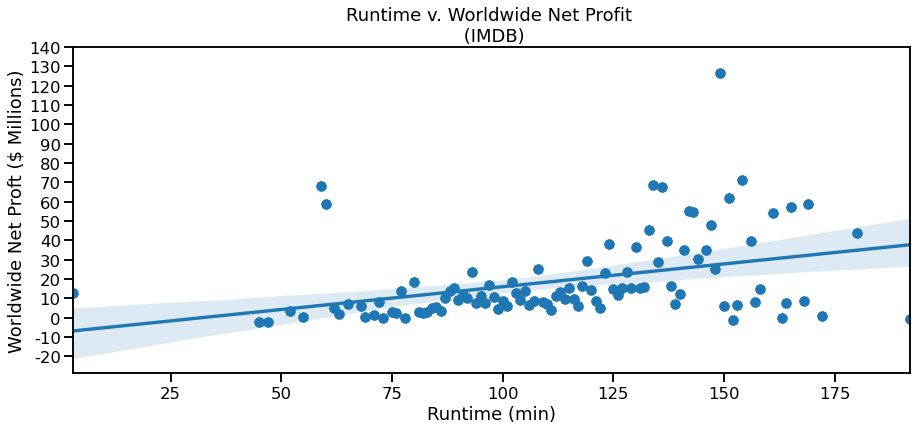

In [33]:
fig, ax = plt.subplots(figsize = (15,6))

x = only_us_merged.groupby('runtime_minutes')['Worldwide Net Profit'].mean().index
y = only_us_merged.groupby('runtime_minutes')['Worldwide Net Profit'].mean().values

sns.regplot(x,y)

ax.scatter(x,y)
ax.set_xlabel('Runtime (min)')
ax.set_ylabel('Worldwide Net Proft ($ Millions)')
ax.set_title('Runtime v. Worldwide Net Profit \n (IMDB)')
ax.set_yticks(range(-200000000,1500000000, 100000000))
ax.set_yticklabels(range(-20,150,10));

### Correlation between the two variables

In [34]:
corr_1 = round(only_us_merged.corr()['runtime_minutes']['Worldwide Net Profit'], 2)
print(f'The correlation between runtime and worlwide net profits is {corr_1}')

The correlation between runtime and worlwide net profits is 0.27


When looking for a relationship between `runtime` and `worldwide net profits` we found a very weak correlation between the two variables. The correlation between the two variables is *0.27*, and looking at the scatter plot there is a tendency of the data below 120 minutes to have a low variance. However, when the runtime exceeds 125 minutes the variance of the data fluctuates greatly and no reasonable conclusion can be drawn from this. 

### Plotting `Runtime` vs `Average Rating` (Manav)

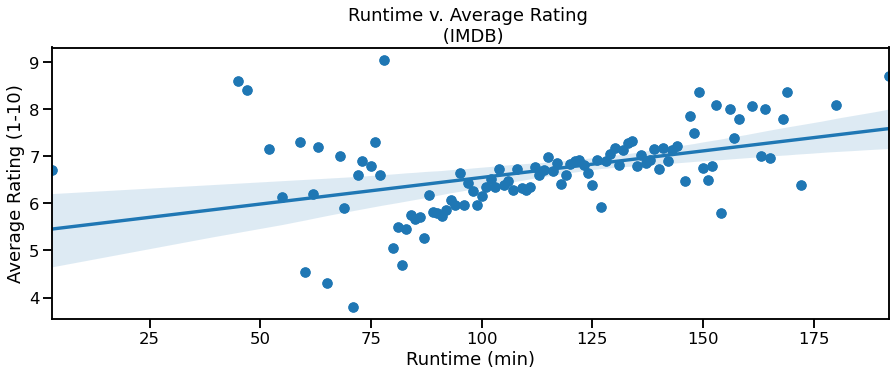

In [35]:
fig, ax = plt.subplots(figsize = (15,5))

x = only_us_merged.groupby('runtime_minutes')['averagerating'].mean().index
y = only_us_merged.groupby('runtime_minutes')['averagerating'].mean().values

sns.regplot(x,y)

ax.scatter(x,y)
ax.set_xlabel('Runtime (min)')
ax.set_ylabel('Average Rating (1-10)')
ax.set_title('Runtime v. Average Rating \n (IMDB)');

### Correlation matrix between the two variables

In [36]:
corr_2 =  round(only_us_merged.corr()['runtime_minutes']['averagerating'], 2)

print(f'The correlation bewtween runtime and average rating is {corr_2}')

The correlation bewtween runtime and average rating is 0.39


When looking for a relationship between `runtime` and `average rating` we found a weak correlation between the two variables. The correlation between the two variables is *0.39*. However, this does not provide a good context of the data when looking at the scatter plot. We can see that most of the data below 90 minutes has a very large variance, and most of the data above 140 minutes has a greater than expected variance. While most of the data between 90 minutes and 140 minutes does have very low variance and some of the data is within our 95% confidence interval. We would be unable to make any reasonable conclusion from the data below 90 minutes and 140 minutes, and drawing a conclusion from the data between those two intervals would not account for any confounding variable. 

### Plotting Profit by Genre & Year (Nina)

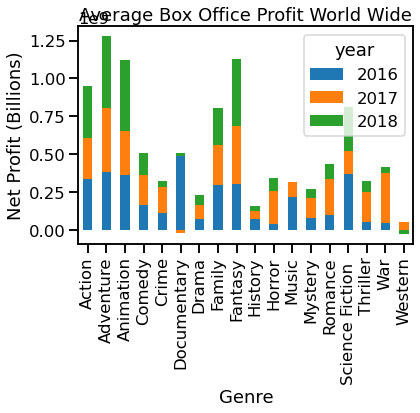

'\nFrom this plot, we see a consistent return on action, adventure, animation, and scifi films. \nAdventure, Animation, and Fantasy are the top three genres with the highest profit margin\n'

In [37]:
#A Dictionary containing the genre_id key mappings 
genre_dict= {
             28:'Action' 
             ,12:'Adventure' 
             ,16:'Animation' 
             ,35:'Comedy' 
             ,80:'Crime' 
             ,99:'Documentary' 
             ,18:'Drama' 
             ,10751:'Family' 
             ,14:'Fantasy' 
             ,36:'History' 
             ,27:'Horror' 
             ,10402:'Music' 
             ,9648:'Mystery' 
             ,10749:'Romance' 
             ,878: 'Science Fiction '
             ,10770: 'TV  Movie' 
             ,53:'Thriller' 
             ,10752:'War' 
             ,37:'Western' 
 }
df = cleaner_imdb = pd.read_csv('data/imdb_cleaned_final.csv')
 #Creates a new column 'genre_str' from the mapped genre_dict
df['genre_str'] = df['genre_id'].map(genre_dict)
df.dropna(axis='rows', subset=['genre_id'], inplace=True)


#filter the data for movies released from 2016-2020 and return the genre, world wide profit, and year columns
world_wide = df.loc[df['year'].isin(range(2016,2020))][['genre_str', 'year', 'Worldwide Net Profit']]
#create a pivot table containing the year, genre and average net profit
pivot = world_wide.pivot_table(columns='year', index='genre_str', values='Worldwide Net Profit')

#plots the above pivot table 
ax = pivot.plot.bar(stacked=True)
ax.set_ylabel('Net Profit (Billions)')
ax.set_xlabel('Genre')
ax.set_title('Average Box Office Profit World Wide');
plt.show()
'''
From this plot, we see a consistent return on action, adventure, animation, and scifi films. 
Adventure, Animation, and Fantasy are the top three genres with the highest profit margin
'''

### Plotting Profit By Release Month & Genre (Nina)

'\nAccording to the pivot table and bar chart:\nFantasy has its highest profits in April, June, and November\nAnimation has its highest profits in June, February, and July\nAnd Adventure has its highest profits in June, December, and November\n'

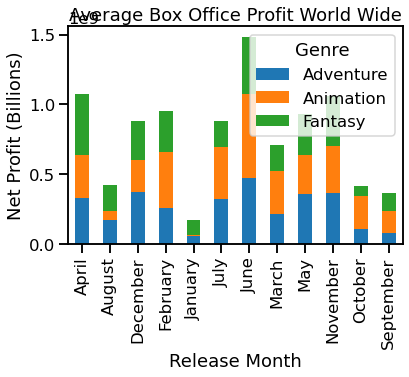

In [38]:
'''
Creates a dictionary of the numeric months paired with their string value.
This dictionary is mapped over 'release_month' column to create a 'release_month_str' column
'''
month_dict = dict(zip(range(1,13), month_name[1:]))
df['release_month_str'] = df['release_month'].map(month_dict)


#Filters the dataframe for movies that are classified as the one of the top three most profitable genres
target_genres = df[df['genre_str'].isin('Adventure Animation Fantasy'.split())]

#Creates a pivot table with Genre as columns, release month as index, and average worldwide profit as values
genre_month_released_profit = target_genres.pivot_table(columns='genre_str', index='release_month_str', values='Worldwide Net Profit')
genre_month_released_profit.columns.name = 'Genre'

'''
Creates a stacked bar plot:
    Each bar represents a month
    Values that make up the bar are grouped by genre
    y-axis is Net Profit
'''
ax = genre_month_released_profit.plot.bar(stacked=True)
ax.set_ylabel('Net Profit (Billions)')
ax.set_xlabel('Release Month')
ax.set_title('Average Box Office Profit World Wide');
'''
According to the pivot table and bar chart:
Fantasy has its highest profits in April, June, and November
Animation has its highest profits in June, February, and July
And Adventure has its highest profits in June, December, and November
'''

In [39]:
def bar(height,y,x_label,y_tick_label, y_label,  title,):
    #Initialize figure and create bar plot on figure axis
    fig, ax = plt.subplots()
    ax.barh(y,height)
    
    #Sets plot axis and title parameters
    ax.set_title(title)
    ax.set_yticks(range(len(y)))
    ax.set_yticklabels(y_tick_label)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label) 

### Addtional Plots (Nina)

"\nWe can see that the average user rating isn't influenced by genre\nbecause they don't appear to be significantly different. \n"

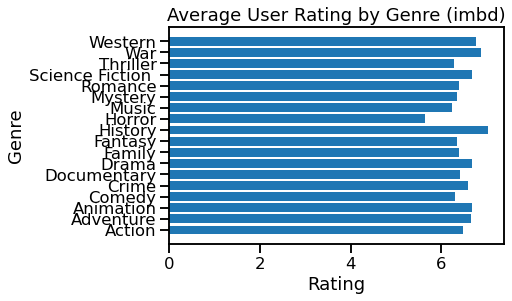

In [40]:
#Filter's df for rows where numvotes is at least 100
rating_df = df.loc[df['numvotes'] >=100, ['genre_str', 'averagerating']]

#Groups the filtered data by genre and takes the mean of the 'averagerating' column
average_rating_genre = df.groupby('genre_str')['averagerating'].mean()

#Uses a horizontal bar chart to display each genres (x axis) average user rating
bar(
    average_rating_genre.values
    ,range(len(average_rating_genre))
    ,'Rating'
    ,average_rating_genre.index.values
    ,'Genre'
    ,'Average User Rating by Genre (imbd)'
)
'''
We can see that the average user rating isn't influenced by genre
because they don't appear to be significantly different. 
'''

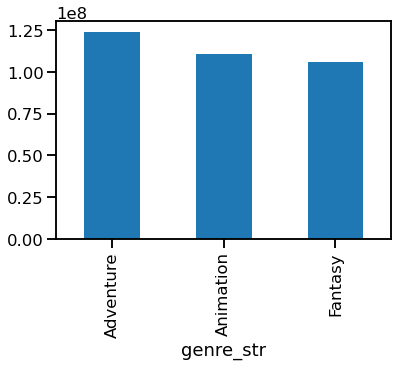

In [41]:
df.columns
budget_by_genre = target_genres.groupby('genre_str')['production_budget'].mean()
ax = budget_by_genre.plot.bar()

### Plotting Profit by Release Month (Ben B.)
Using our combined dataset, imdb_cleaned, we are further investigating an additional question:  are there higher box office returns for movies released during certain months?  And, additionally, are movies released in certain months for critically acclaimed?

In [42]:
#drop all movie duplicates since I'm only interested in the release month
imdb_cleaned = only_us_merged.drop_duplicates(subset='tconst')

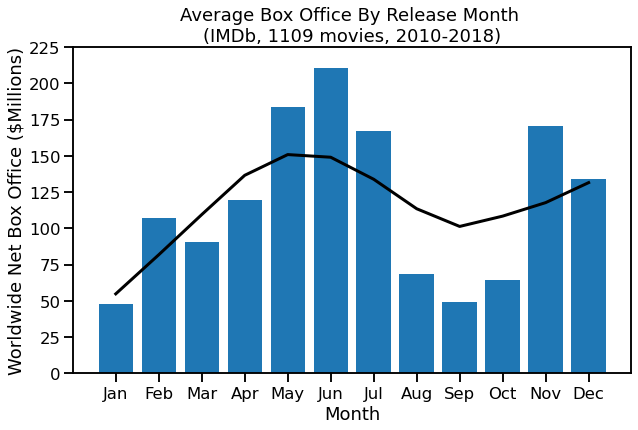

In [43]:
#create a plot WW net BO by release month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned.groupby('release_month')['Worldwide Net Profit'].mean().index
y = imdb_cleaned.groupby('release_month')['Worldwide Net Profit'].mean().values
ax.bar(x,y)
ax = sns.regplot(x, y, scatter = False,  color = 'black', lowess = True, line_kws={'linewidth':3})

ax.set_xlabel('Month')
ax.set_ylabel('Worldwide Net Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(0,250000000,25000000))
ax.set_yticklabels(range(0,250,25))

month_starts = range(1,13,1)
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names);

Note:  The plot shows strong returns for movies released in the spring months (May, June, Jul) as well as at the end of the year (Nov, Dec).  

### Plotting IMDb rating by Release Month (Ben)

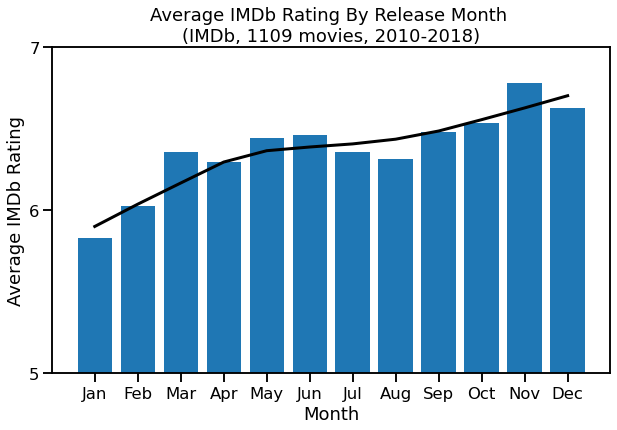

In [44]:
#create a plot average IMDb rating by relase month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned.groupby('release_month').averagerating.mean().index
y = imdb_cleaned.groupby('release_month').averagerating.mean().values
ax.bar(x,y)
ax = sns.regplot(x, y, scatter = False,  color = 'black', lowess = True, line_kws={'linewidth':3})

ax.set_xlabel('Month')
ax.set_ylabel('Average IMDb Rating')
ax.set_title('Average IMDb Rating By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(5,8,1))
ax.set_yticklabels(range(5,8,1))
ax.set_ylim(bottom=5, top=7)

month_starts = range(1,13,1)
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names);

Note:  IMDb rating tends to increase as the year progresses.  This intuitivley makes sense, since movies vying for Oscar attention schedule their releases closer to the nomination period.

### Additional Plots (Nate)

In [45]:
# Loading Manav's final dataframe
# making a copy of the dataframe and assigning it to
# the variabable cleaner
cleaner_imdb = pd.read_csv('data/imdb_cleaned_final.csv')
cleaner = cleaner_imdb.copy()

In [46]:
# drop duplicates based on tconst redundancies
cleaner.drop_duplicates(subset = "tconst",  inplace = True)

### Plotting Profit by Production Budget (Nate)

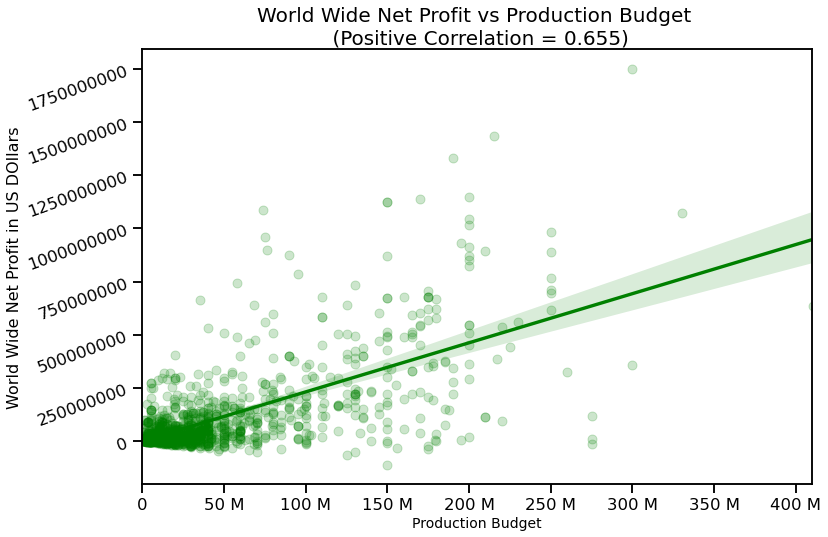

In [47]:
# Scatter plot of production_budget vs Worldwide Net Profit
budget = cleaner['production_budget']
profit = cleaner['Worldwide Net Profit']

fig, ax = plt.subplots(figsize=(12,8))

ax = sns.regplot(x='production_budget', y=profit, data = cleaner, color='green', scatter_kws={'alpha':0.2});


ax.set_facecolor('white')
ax.set_xlabel('Production Budget', size=14)
ax.set_ylabel('World Wide Net Profit in US DOllars', size=16)
ax.set_title('World Wide Net Profit vs Production Budget \n (Positive Correlation = 0.655)', size =20)

ax.set_xlim(0, 410000000)
plt.yticks(rotation=20)


ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.ticklabel_format(style='plain', axis='y');

In [48]:
#World Wide Net Prof vs Poduction Budget correlation
cleaner['Worldwide Net Profit'].min()#['production_budget']['Worldwide Net Profit']

-110450242

The Production Budget vs Worldwide Net Profits scatter plot (above in green) shows that there seems to be a slightly strong correllation between how much a studio spends on a film and how much it profits on the world market. These figures could be interpeted as the more money spent equals more money accrued. However, it should be taken into account that the highest loss of any film world wide was $110,450,242. As a precaution it may be in the studio's best
interest to not produce all big budget movies in its infancy as a company. Perhaps reference independent studios such
as A24 for ideas on smaller budget productions that make robust profits, earn fans' admiration, while maintaining artistic integrity. 

### Plotting Budget vs. IMDb Rating (Nate)

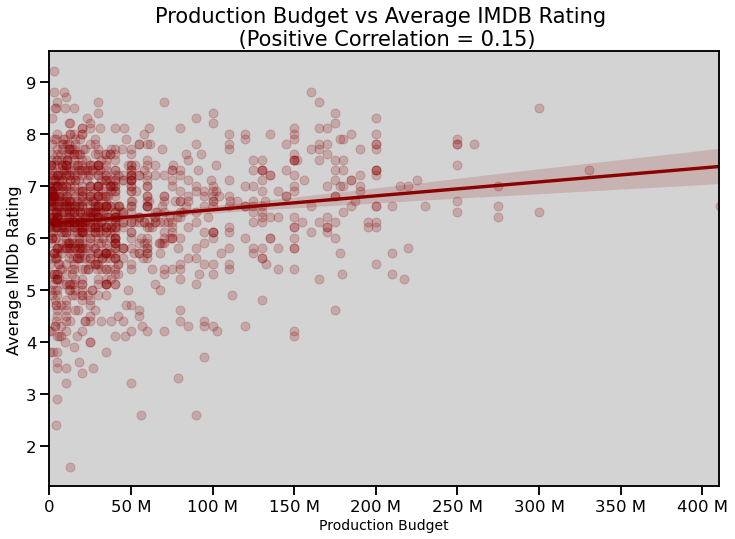

In [49]:
#Scatter plot of production_budget vs averagerating

rating = cleaner['averagerating']

fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x=budget, y=rating, data = cleaner, color='darkred', scatter_kws={'alpha':0.2})

ax.set_facecolor('lightgrey')
ax.set_xlabel('Production Budget',size=14)
ax.set_ylabel('Average IMDb Rating', size=16)
ax.set_title('Production Budget vs Average IMDB Rating \n (Positive Correlation = 0.15)', size =21)
ax.set_xlim(0, 410000000)
ax.xaxis.set_major_formatter(ticker.EngFormatter());

In [50]:
cleaner.corr()['production_budget']['averagerating']

0.15091492158356226

The Production Budget vs Average IMDB Rating coupled with the correlation figures show that there is very low 
positive correlation between production budget and IMDb ratings. 
Therefore, decisions on which films to make should not be based 
upon IMDb reviews. As much as Twitter might have you believe.

### Plotting Profit by IMDb Rating (Nate)

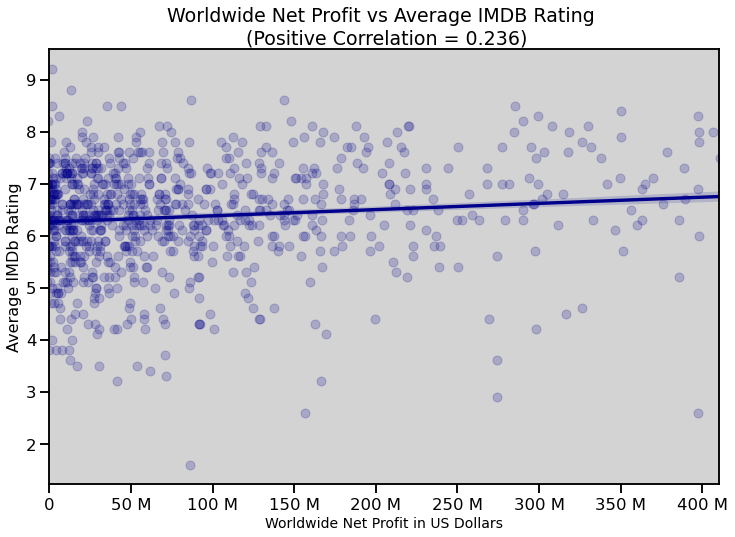

In [51]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x=profit, y=rating, data = cleaner, color='darkblue', scatter_kws={'alpha':0.2})

ax.set_facecolor('lightgrey')
ax.set_xlabel('Worldwide Net Profit in US Dollars',size=14)
ax.set_ylabel('Average IMDb Rating', size=16)
ax.set_title('Worldwide Net Profit vs Average IMDB Rating \n (Positive Correlation = 0.236)', size =19)
ax.set_xlim(0, 410000000)
ax.xaxis.set_major_formatter(ticker.EngFormatter());

In [52]:
cleaner.corr()['Worldwide Net Profit']['averagerating']

0.2361185196365939

The Worldwide Net Profit vs Average IMDb Rating scatter plot along with the correlation calculation 
shows that there is a low positive correlation between Net Profit and user ratings. It is however, slightly 
higher than the correlation between Production Budget and Average IMDb rating. This could be due to more people
paying to see the films or repeated viewings which would, one could surmise, lead to more favorable reviews.

## Rotten Tomatoes Databases (Ben B.)
rt_movies is a dataset from Rotten Tomatoes of 1560 records over 12 columns.  Unfortunately, there are no movie titles, so it is not possible to merge this dataset with the imdb_cleaned dataset.  Therefore this rt_movies will remain an 'island'. Another downside is that the box_office records are limited to 340.  Nevertheless, we used this dataset to further elucidate the merged dataset. (Note:  it is not specified whether box office numbers are domestic or worldwide but, given the values, we are assuming these are gross domestice numbers.  This will contrast with our larger combined dataset which uses a worldwide net.)
### rt_movies.csv
### Cleaning rt_movies

In [53]:
rt_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [54]:
#Create rt_movies_cleaned. Drop 359 movies with no theater date.  Only reduces records with B.O. from 340 to 334.
rt_movies_cleaned = rt_movies.dropna(axis=0, subset=['theater_date'])

#Create new column 'year' for int year, and 'month' for the month str.
rt_movies_cleaned['year'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[-1])
rt_movies_cleaned['month'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[0])

#Remove all movies with no box office records.  Now have 334 records.
rt_movies_cleaned.dropna(axis=0, subset=['box_office'], inplace=True)
rt_movies_cleaned.reset_index(inplace=True)
rt_movies_cleaned.drop('index', axis=1, inplace=True)

In [55]:
#Remove commas from B.O. column
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: x.replace(',',''))

#Convert B.O. to ints
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: int(x))

#Convert years to ints
rt_movies_cleaned.year = rt_movies_cleaned.year.apply(lambda x: int(x))

In [56]:
#Remove all movies before 2000.  Reduces records to 326.
rt_movies_cleaned = rt_movies_cleaned[rt_movies_cleaned.year >= 2000]

In [57]:
#Find movie with rating NC17, then drop the record.  There are 325 records remaining.  
rt_movies_cleaned[rt_movies_cleaned.rating == 'NC17'].index

Int64Index([259], dtype='int64')

In [58]:
rt_movies_cleaned.drop(259, axis=0, inplace=True)

## rt_movies Analysis

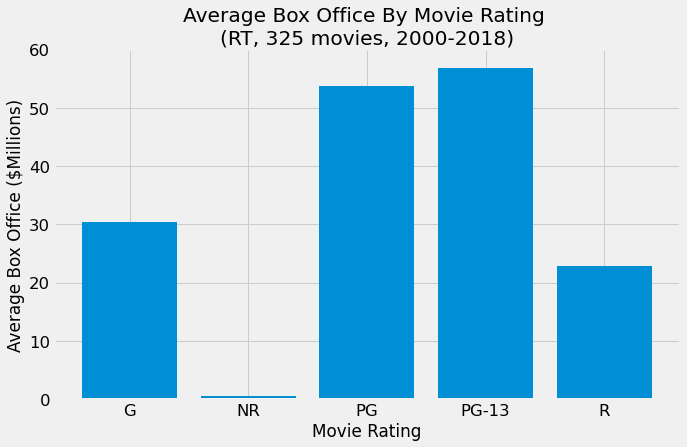

In [59]:
#Rotten Tomatoes db of 325 movies from 2000 to 2018
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('rating').box_office.mean().index
y = rt_movies_cleaned.groupby('rating').box_office.mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Movie Rating \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

In [60]:
rt_movies_cleaned.rating.value_counts()

R        139
PG-13    115
PG        49
NR        13
G          9
Name: rating, dtype: int64

Note:  There are only 9 G rated films included in the above plot, therefore we should not strongly rely on it's conclusions.

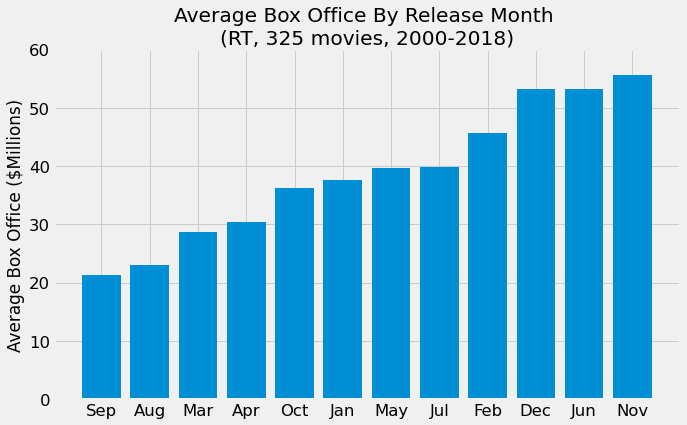

In [61]:
#Create a plot of Average BO by release month from rt_movies_cleaned
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().index
y = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

The above plot is a useful comparison to a similar plot generated with the larger dataset.

### rt_movies_runtime
Clean the dataset further to examine movie runtime vs. box office.

In [62]:
#create a subset of rt_movies_cleaned to remove NaNs from runtime, leaving 323 records
rt_movies_runtime = rt_movies_cleaned.dropna(axis=0, subset=['runtime'])

In [63]:
#create a new column 'minutes' that contains minutes in ints
rt_movies_runtime['minutes'] = rt_movies_runtime.runtime.apply(lambda x: int(x.split()[0]))

In [64]:
#Find the correlation between box office and runtime.
rt_movies_runtime.corr()

,id,box_office,year,minutes
id,1.000000,0.079440,0.015652,0.031163
box_office,0.079440,1.000000,-0.165534,0.232658
year,0.015652,-0.165534,1.000000,0.099582
minutes,0.031163,0.232658,0.099582,1.000000


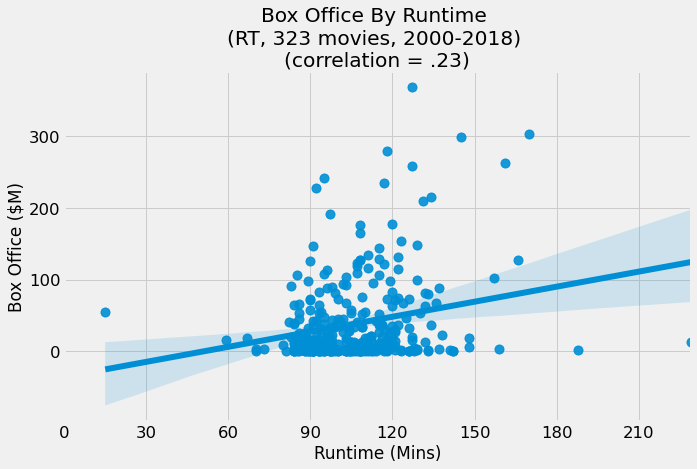

In [65]:
#Scatter plot of B.O. by runtime from RT db with 323 movies from 2000-2018
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_runtime.minutes
y = rt_movies_runtime.box_office
ax.scatter(x=x, y=y, alpha=.5)
sns.regplot(x=x,y=y)
ax.set_xlabel('Runtime (Mins)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office By Runtime \n(RT, 323 movies, 2000-2018) \n(correlation = .23)')
ax.set_xticks(range(0,240, 30))
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

Note:  There is a weak positive correlelation between runtime and box office.  The above plot will be compared to a similar plot generated with the larger dataset.

### rt_movies_directors
Further cleaning to inspect box office by director.

In [66]:
#create rt_movies_directors with 286 records by dropping NaNs from rt_movies_cleaned
rt_movies_directors = rt_movies_cleaned.dropna(axis=0, subset=['director'])

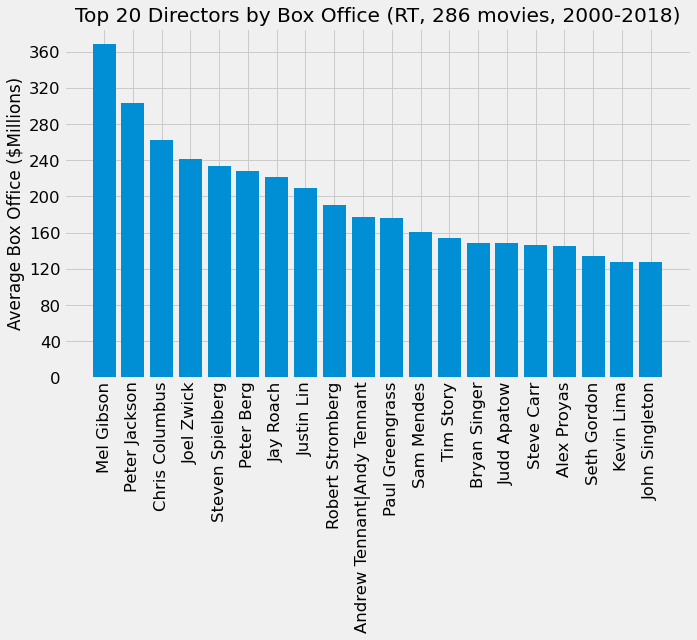

In [67]:
#Plot top 20 directors by mean B.O. Not very informative because most directors have only one movie listed.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].index
y = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Top 20 Directors by Box Office (RT, 286 movies, 2000-2018)')
ax.set_xticks(range(20))
ax.set_xticklabels(x, rotation=90)
ax.set_yticks(range(0,400000000,40000000))
ax.set_yticklabels(range(0,400,40));

Note:  The above plot is rather useless because most directors have only one or two movies in the dataset.  Mel Gibsion's movie, for example, is probably 'Passion of the Christ', which was a b.o. smash, but that doesn't tell us anything about his other directorial ventures.

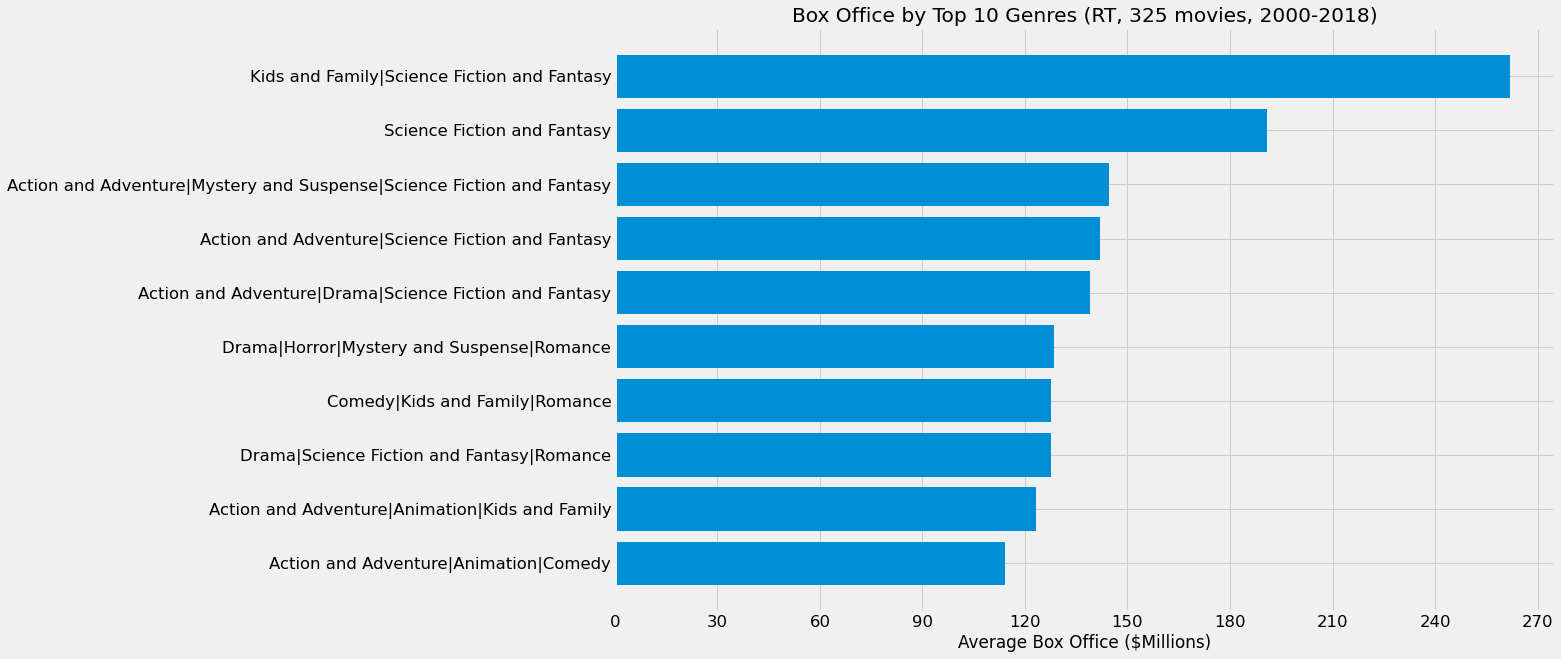

In [68]:
#Create a plot showing top 10 genres by B.O. using rt_movies_cleaned (325 records)
fig, ax = plt.subplots(figsize=(15,10))
x = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().index
y = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Box Office ($Millions)')
ax.set_title('Box Office by Top 10 Genres (RT, 325 movies, 2000-2018)')
ax.set_xticks(range(0,300000000,30000000))
ax.set_xticklabels(range(0,300,30));

Note:  The above plot will be a useful comparison with one generated from the larger datasets.

## rt_reviews.csv
rt_reviews is another Rotten Tomatoes dataset with 54,432 records over 8 columns.  It consists of reviews for each movie id as well as RT ratings.  Most movies have many reviews, though only some of them are from top critics.  We are attempting to find a correlation between top critics' opinion and box office return.  This dataset will be filtered to only top critics and merged with rt_movies to generate the plot.

In [69]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [70]:
#Remove all records where top_critic = 0. Reduces rt_reviews from 54,432 to 13,096 records
rt_reviews = rt_reviews[rt_reviews.top_critic == 1]

In [71]:
#Create new column 'fresh_value' that is 1 for 'fresh' movies or 0 for 'rotten' movies.
rt_reviews['fresh_value'] = rt_reviews.fresh.apply(lambda x: 1 if x == 'fresh' else 0)

In [72]:
#Create a series of the percentage of fresh reviews for each movie id (889 records)
total_reviews = rt_reviews.groupby('id').fresh_value.count()
fresh_reviews = rt_reviews.groupby('id').fresh_value.sum()
fresh_percent = fresh_reviews / total_reviews 

In [73]:
#Create a series of the number of reviews for each movie id (889 records)
num_reviews = rt_reviews.groupby('id').id.count()

In [74]:
#Merege the two series and rename the columns
merge_fresh_and_num_reviews = pd.concat([fresh_percent, num_reviews], axis=1)
merge_fresh_and_num_reviews.rename(columns={'id':'num_reviews'}, inplace=True)

In [75]:
#Remove all records with less than 10 reviews, leaving 447 records.
merge_fresh_and_num_reviews = merge_fresh_and_num_reviews[merge_fresh_and_num_reviews.num_reviews >= 10]

In [76]:
#inner merge rt_movies_cleaned with the series fresh percent into rt_movies_cleaned_reviews (268 records)
rt_movies_cleaned_reviews = rt_movies_cleaned.merge(merge_fresh_and_num_reviews, how='inner', on='id')

In [77]:
#Find the correlation between box office and fresh_value
rt_movies_cleaned_reviews.corr()['box_office']['fresh_value']

0.03613542398884145

### rt_reviews Analysis

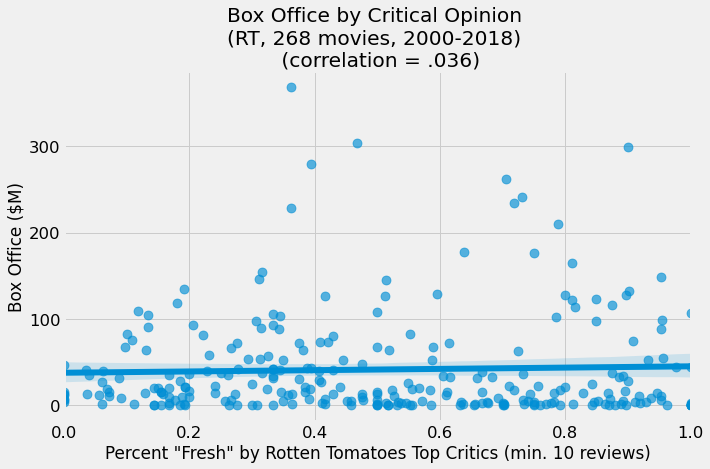

In [78]:
#Create a scatter plot of BO and critical opinion.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned_reviews.fresh_value
y = rt_movies_cleaned_reviews.box_office
ax.scatter(x, y , alpha=.5)
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.3})
ax.set_xlabel('Percent \"Fresh\" by Rotten Tomatoes Top Critics (min. 10 reviews)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 268 movies, 2000-2018) \n (correlation = .036)')
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

As you can see, there is almost no correlation between RT top critics opinion and box office returns.

## Rotten Tomatoes Data From Kaggle (Ben)
We further investigate Rotten Tomatoes using a dataset from Kaggle.  This data was webscraped and consists of 17,712 records over 22 columns.  Fortunately, this RT dataset includes the movie title so, unlike rt_movies and rt_reviews, it can be merged with our imdb combined dataset.  We can then investigate worldwide profits vs. MPAA rating, genre, and the RT "tomatometer".

In [79]:
#Set the movie titles to lowercase.  Drop records with no original release date.  
#Add a year col for int years, then drop all movies before the year 2000.
rt_kaggle['movie_title'] = rt_kaggle.movie_title.apply(lambda x: x.lower())
rt_kaggle.dropna(axis=0, subset=['original_release_date'], inplace=True)
rt_kaggle['year'] = rt_kaggle.original_release_date.apply(lambda x: int(x[:4]))
rt_kaggle = rt_kaggle[rt_kaggle.year >= 2000]

In [80]:
#Create a new df from imdb_cleaned_copy with just two columns: primary_title and Worldwide Net Profit.  Then merge 
#on the movie names with rt_kaggle creating a df with 1098 movies.  
imdb_cleaned_title_and_profit = imdb_cleaned[['primary_title','Worldwide Net Profit']]
merge_imdb_rt_kaggle = imdb_cleaned_title_and_profit.\
        merge(rt_kaggle, how='inner', left_on='primary_title', right_on='movie_title')

### rt_kaggle Analysis

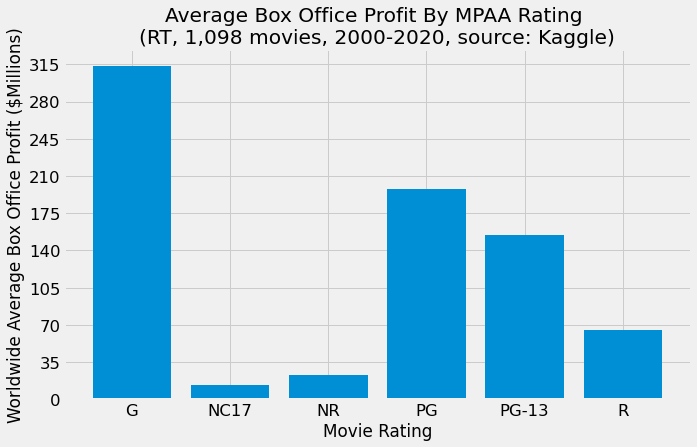

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().index
y = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Worldwide Average Box Office Profit ($Millions)')
ax.set_title('Average Box Office Profit By MPAA Rating \n(RT, 1,098 movies, 2000-2020, source: Kaggle)')
ax.set_yticks(range(0,350000000,35000000))
ax.set_yticklabels(range(0,350,35));

Note:  This graph contrasts with the rt_movies dataset (which suggested PG and PG-13 movies were making the most money) since it suggests that the biggest money-makers are G-rated movies.  This dataset and plot are preferable since a) it uses worldwide profit rather than domestic gross, and b) it's a larger dataset. It still has the weakness, however, of only including 13 G rated films.

In [82]:
merge_imdb_rt_kaggle.content_rating.value_counts()

R        464
PG-13    449
PG       161
G         13
NR        10
NC17       1
Name: content_rating, dtype: int64

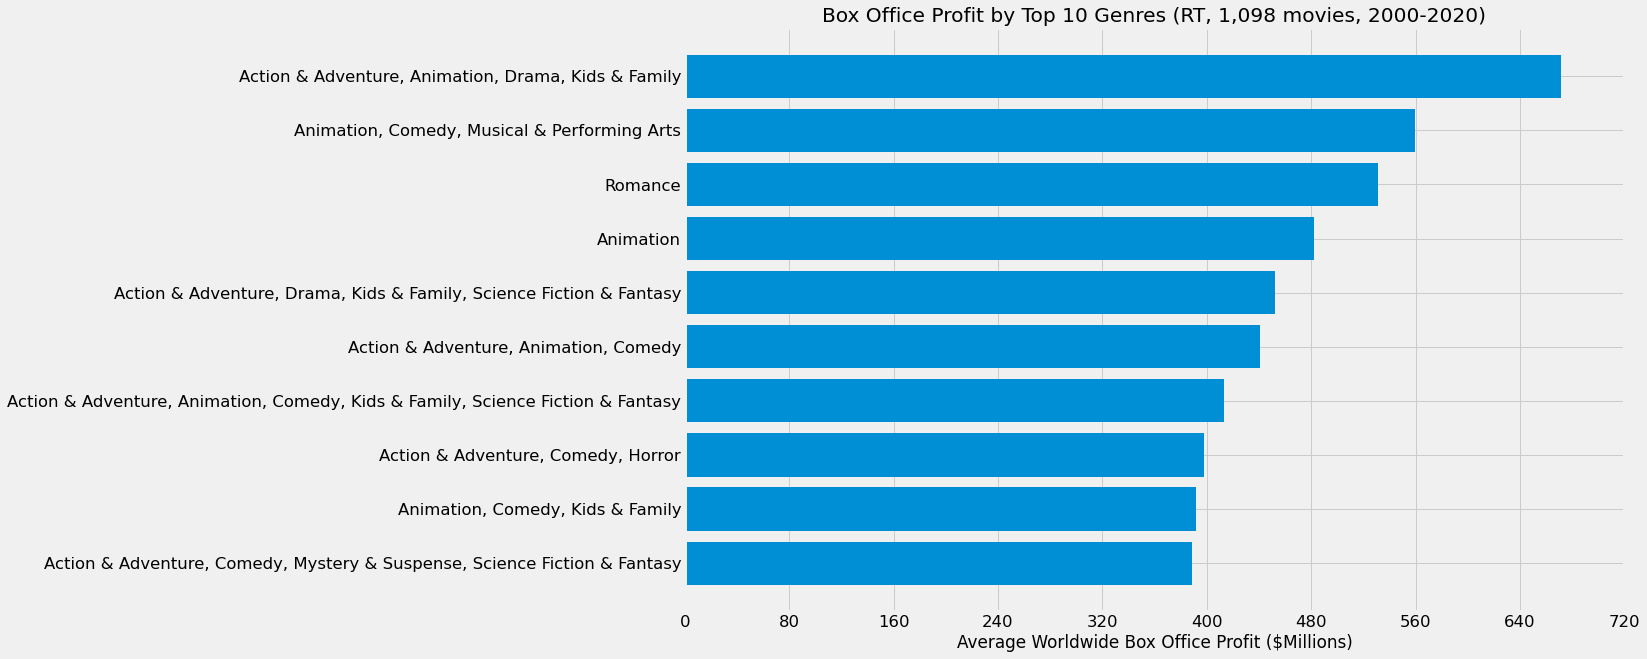

In [83]:
fig, ax = plt.subplots(figsize=(15,10))
x = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().index
y = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Worldwide Box Office Profit ($Millions)')
ax.set_title('Box Office Profit by Top 10 Genres (RT, 1,098 movies, 2000-2020)')
ax.set_xticks(range(0,800000000,80000000))
ax.set_xticklabels(range(0,800,80));

Note:  The above plot also conflicts somewhat with the smaller rt_movies (which suggested sci-fi and fantasy of various flavors had the biggest box office receipts).  This one shows that animated movies do well, as well as romance movies.  Again, this dataset is preferable due to its size and the worldwide profit variable.  

In [84]:
#Drop all records with less than 50 reviews leaving 639 entries. 
#Find the correlation between the Tomatometer and Worldwide profit.
merge_imdb_rt_kaggle = merge_imdb_rt_kaggle[merge_imdb_rt_kaggle.tomatometer_rating >= 50]
merge_imdb_rt_kaggle.corr()['tomatometer_rating']['Worldwide Net Profit']

0.1197788260278433

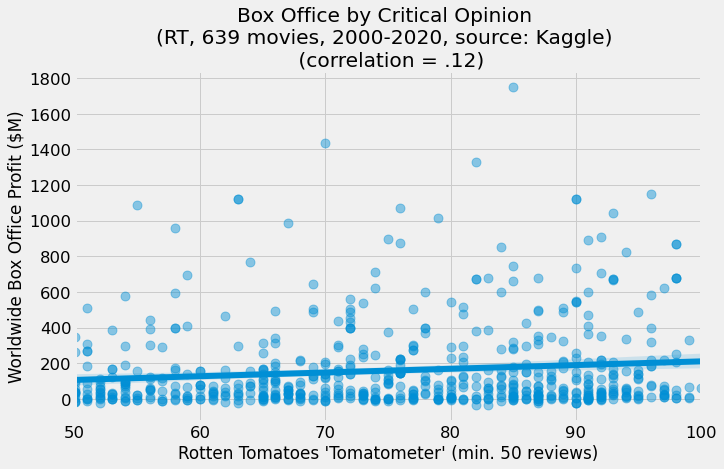

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.tomatometer_rating
y = merge_imdb_rt_kaggle['Worldwide Net Profit']
ax.scatter(x, y , alpha=.2)
sns.regplot(x=x,y=y,scatter_kws={'alpha':0.3})
ax.set_xlabel('Rotten Tomatoes \'Tomatometer\' (min. 50 reviews)')
ax.set_ylabel('Worldwide Box Office Profit ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 639 movies, 2000-2020, source: Kaggle) \n (correlation = .12)')
ax.set_yticks(range(0,2000000000,200000000))
ax.set_yticklabels(range(0,2000,200));

Note:  The above plot confirms the there is little correaltion between critical consensus and box office profits.